# Preparation

In [32]:
import os
import glob
import pandas as pd
from transformers import BertTokenizer, BertModel
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import openpyxl


curfolder = os.getcwd()
answerfolder = curfolder + '/answer_data/'
answerfiles = glob.glob(answerfolder + '*.csv')

# load in one file
df = pd.read_csv(answerfiles[0])
# add a column exp and set values everywhere to 1 - tp keep track what part is it
df['exp'] = 1
df2 = pd.read_csv(answerfiles[1])
df2['exp'] = 2

# concept list
df_concepts = pd.read_excel(answerfolder + '/conceptlist_info.xlsx')

# Function for BERT embeddings

In [12]:
# Function to get BERT embeddings
def get_word_embedding(word):
    inputs = tokenizer(word, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
    # Extract the embeddings of the [CLS] token, which is the aggregate representation
    embeddings = outputs.last_hidden_state[:, 0, :].squeeze()
    return embeddings

# BERT for English

## Preparation

In [13]:

# merge df and df 2
df_all = pd.concat([df, df2], ignore_index=True)

# keep only columns word and answer
df = df_all[['word', 'answer', 'exp']]

# in df_concepts, keep only English and Dutch
df_concepts = df_concepts[['English', 'Dutch']]

# rename Dutch to word
df_concepts = df_concepts.rename(columns={'Dutch': 'word'})

# merge df and df_concepts on word
df = pd.merge(df, df_concepts, on='word', how='left')

# show rows where English is NaN
df[df['English'].isnull()]

# add translations manually for each
df.loc[df['word'] == 'bloem', 'English'] = 'flower'
df.loc[df['word'] == 'dansen', 'English'] = 'to dance'
df.loc[df['word'] == 'auto', 'English'] = 'car'
df.loc[df['word'] == 'olifant', 'English'] = 'elephant'
df.loc[df['word'] == 'comfortabel', 'English'] = 'comfortable'
df.loc[df['word'] == 'bal', 'English'] = 'ball'
df.loc[df['word'] == 'haasten', 'English'] = 'to hurry'
df.loc[df['word'] == 'gek', 'English'] = 'crazy'
df.loc[df['word'] == 'snijden', 'English'] = 'to cut'
df.loc[df['word'] == 'koken', 'English'] = 'to cook'
df.loc[df['word'] == 'juichen', 'English'] = 'to cheer'
df.loc[df['word'] == 'zingen', 'English'] = 'to sing'
df.loc[df['word'] == 'glimlach', 'English'] = 'smile'
df.loc[df['word'] == 'klok', 'English'] = 'clock'
df.loc[df['word'] == 'fiets', 'English'] = 'bicycle'
df.loc[df['word'] == 'vliegtuig', 'English'] = 'airplane'
df.loc[df['word'] == 'geheim', 'English'] = 'secret'
df.loc[df['word'] == 'telefoon', 'English'] = 'telephone'
df.loc[df['word'] == 'zwaaien', 'English'] = 'to wave'
df.loc[df['word'] == 'sneeuw', 'English'] = 'snow'

## BERT

Models here: https://huggingface.co/transformers/v3.3.1/pretrained_models.html

In [14]:
meanings_en = list(df['English'])
len(meanings_en)

answers_nl = list(df['answer'])
answers_nl
len(answers_nl)

answers_en = ['party', 'to cheer', 'tasty', 'to shoot', 'to breathe', 'zombie', 'bee', 'sea', 'dirty', 'tasty', 'car', 'to eat', 'to eat', 'to blow', 'hose', 'hose', 'to annoy', 'to make noise', 'to make noise', 'to run away', 'elephant', 'to cry', 'cold', 'outfit', 'silence', 'to ski', 'wrong', 'to play basketball', 'to search', 'disturbed', 'to run', 'to lick', 'to lift', 'lightning', 'to think', 'to jump', 'to fall', 'to write', 'to dance', 'shoulder height', 'horn', 'dirty', 'boring', 'to drink', 'strong', 'elderly', 'to mix', 'fish', 'fish', 'dirty', 'wrong', 'smart', 'to box', 'to box', 'dog', 'to catch', 'to cheer', 'to sing', 'pregnant', 'hair', 'to shower', 'pain', 'burnt', 'hot', 'I', 'to chew', 'bird', 'airplane', 'to fly', 'to think', 'to choose', 'to doubt', 'graffiti', 'fireworks', 'bomb', 'to smile', 'to laugh', 'smile', 'clock', 'to wonder', 'height', 'big', 'height', 'space', 'to misjudge', 'to wait', 'satisfied', 'happy', 'fish', 'to smell', 'wind', 'pain', 'to burn', 'hot', 'to cycle', 'to fly', 'airplane', 'bird', 'to crawl', 'to drink', 'waterfall', 'water', 'fire', 'top', 'good', 'to hear', 'to point', 'distance', 'there', 'to whisper', 'quiet', 'to be silent', 'telephone', 'to blow', 'to distribute', 'to give', 'cat', 'to laugh', 'tasty', 'to eat', 'yummy', 'to sleep', 'mountain', 'dirty', 'to vomit', 'to be disgusted', 'to greet', 'hello', 'goodbye', 'to smell', 'nose', 'odor', 'to fly', 'fireworks', 'to blow', 'to cut', 'pain', 'hot', 'to slurp', 'to throw', 'to fall', 'to fall', 'whistle', 'heartbeat', 'mouse', 'to hit', 'to catch', 'to grab', 'to throw', 'to fall', 'to shoot', 'circus', 'trunk', 'to fall', 'to fight', 'pain', 'to push open', 'to growl', 'to cut', 'to eat', 'knife', 'to slurp', 'to drink', 'drink', 'to eat', 'delicious', 'tasty', 'to cough', 'sick', 'to cry', 'to cry']
len(answers_en)

# add those to df as answers_en
df['answer_en'] = answers_en

tokenizer = BertTokenizer.from_pretrained('bert-large-cased')
model = BertModel.from_pretrained('bert-large-cased')

# Calculate embeddings
guessed_embeddings_en = [get_word_embedding(word) for word in meanings_en]
answer_embeddings_en = [get_word_embedding(word) for word in answers_en]

# Calculate cosine similarities
similarities_en = [cosine_similarity([guessed_emb], [answer_emb])[0][0] for guessed_emb, answer_emb in zip(guessed_embeddings_en, answer_embeddings_en)]

# Print similarities
for guessed_word, answer, similarity in zip(meanings_en, answers_en, similarities_en):
    print(f"Cosine similarity between '{guessed_word}' and '{answer}': {similarity:.4f}")

# calculate euclidian similarity
def euclidean_similarity(a, b):
    return np.linalg.norm(a - b)

# Calculate euclidean similarities
euclidean_similarities_en = [euclidean_similarity(guessed_emb, answer_emb) for guessed_emb, answer_emb in zip(guessed_embeddings_en, answer_embeddings_en)]

# Print similarities
for guessed_word, answer, similarity in zip(meanings_en, answers_en, euclidean_similarities_en):
    print(f"Euclidean distance between '{guessed_word}' and '{answer}': {similarity:.4f}")

# save both to df
df['cosine_similarity'] = similarities_en
df['euclidean_similarity'] = euclidean_similarities_en

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Cosine similarity between 'flower' and 'party': 0.1611
Cosine similarity between 'to dance' and 'to cheer': 0.6847
Cosine similarity between 'bitter' and 'tasty': 0.0824
Cosine similarity between 'to fight' and 'to shoot': 0.9472
Cosine similarity between 'to breathe' and 'to breathe': 1.0000
Cosine similarity between 'to bite' and 'zombie': 0.1149
Cosine similarity between 'buzz' and 'bee': 0.3036
Cosine similarity between 'to whisper' and 'sea': 0.2001
Cosine similarity between 'disgusted' and 'dirty': 0.5769
Cosine similarity between 'slow' and 'tasty': 0.1721
Cosine similarity between 'car' and 'car': 1.0000
Cosine similarity between 'to eat' and 'to eat': 1.0000
Cosine similarity between 'egg' and 'to eat': 0.7380
Cosine similarity between 'to swim' and 'to blow': 0.9247
Cosine similarity between 'fast' and 'hose': 0.2723
Cosine similarity between 'rain' and 'hose': 0.2141
Cosine similarity between 'angry' and 'to annoy': 0.1360
Cosine similarity between 'noisy' and 'to make noise

# Similarity survey

In [15]:
# load in excel similarity_en_survey
df_survey = pd.read_excel(answerfolder + '/similarity_en_survey.xlsx')

# get rid of Timestamp column
df_survey = df_survey.drop(columns='Timestamp')

# for each column, calculate the mean and save it to a df
df_survey_means = pd.DataFrame(df_survey.mean()).reset_index()

# separate the index, the first part is English, the second part is the answer_en
df_survey_means['English'] = df_survey_means['index'].str.split(' - ').str[0]
df_survey_means['answer_en'] = df_survey_means['index'].str.split(' - ').str[1]

# get rid of the index column
df_survey_means = df_survey_means.drop(columns='index')

# rename the column 0 to mean_similarity
df_survey_means = df_survey_means.rename(columns={0: 'mean_similarity'})

# change to lightning into lightning
df_survey_means.loc[df_survey_means['answer_en'] == 'to lightning', 'answer_en'] = 'lightning'
# phone to telephone
df_survey_means.loc[df_survey_means['answer_en'] == 'phone', 'answer_en'] = 'telephone'
# scent to odor
df_survey_means.loc[df_survey_means['answer_en'] == 'scent', 'answer_en'] = 'odor'

In [16]:
# merge df_survey_means with df on English and answer_en
df_final = pd.merge(df, df_survey_means, on=['English', 'answer_en'], how='left')

# get rid of English 'to beat'
df_final = df_final[df_final['English'] != 'to beat']
# and to weep
df_final = df_final[df_final['English'] != 'to weep']

In [17]:
# show me the rows where mean_similarity is NaN
df_final[df_final['mean_similarity'].isnull()]

# mean_similarity of row where English is sharp and answer_en is pain is 4.0 (don't know why it's NaN)
df_final.loc[(df_final['English'] == 'sharp') & (df_final['answer_en'] == 'pain'), 'mean_similarity'] = 4.0

In [18]:
# correlation between cosine_similarity and mean_similarity
print(df_final['cosine_similarity'].corr(df_final['mean_similarity']))


# and euclidean_similarity and mean_similarity
print(df_final['euclidean_similarity'].corr(df_final['mean_similarity']))

# So it seems that the euclidean_similarity correlates better with the survey results than the cosine_similarity


0.5936420578375975
-0.7125549637795267


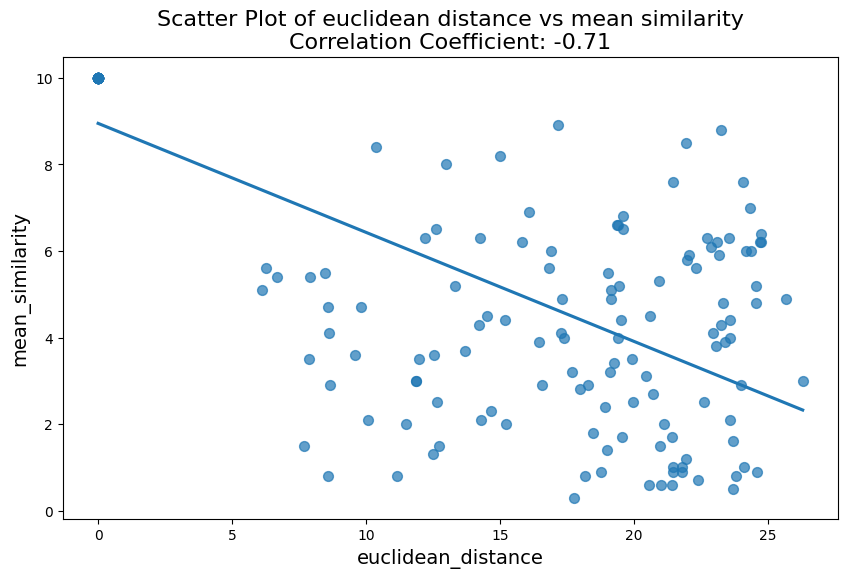

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Compute the correlation coefficient
corr_coef, _ = pearsonr(df_final['euclidean_similarity'], df_final['mean_similarity'])

# Create scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=df_final['euclidean_similarity'], y=df_final['mean_similarity'], data=df, ci=None, scatter_kws={'s': 50, 'alpha': 0.7})

# Customize plot
plt.title(f'Scatter Plot of euclidean distance vs mean similarity\nCorrelation Coefficient: {corr_coef:.2f}', fontsize=16)
plt.xlabel('euclidean_distance', fontsize=14)
plt.ylabel('mean_similarity', fontsize=14)

# Show plot
plt.show()

In [20]:
df_final

,word,answer,exp,English,answer_en,cosine_similarity,euclidean_similarity,mean_similarity
0,bloem,feest,1,flower,party,0.161149,23.574501,2.1
1,dansen,juichen,1,to dance,to cheer,0.684747,12.545033,3.6
2,bitter,lekker,1,bitter,tasty,0.082420,26.284916,3.0
3,vechten,schieten,1,to fight,to shoot,0.947234,6.124245,5.1
4,ademen,ademen,1,to breathe,to breathe,1.000000,0.000000,10.0
...,...,...,...,...,...,...,...,...
165,dik,heerlijk,2,thick,delicious,0.182059,21.110804,2.0
166,dik,lekker,2,thick,tasty,0.807506,12.705090,1.5
167,ziek,hoesten,2,sick,to cough,0.131773,23.096788,6.2
168,ziek,ziek,2,sick,sick,1.000000,0.000000,10.0


In [21]:
# save as csv
df_final.to_csv(answerfolder + '/similarity_comparison.csv', index=False)

# Density

Now we want to know how is concept's environemnt dense. We will use BERT embeddings for this, and then define density as a mean of cosine similarities between all pairs of embeddings.

But we cannot run it on the whole model corpora, so we will sample 10000 keys

## English

In [11]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-cased')
model = BertModel.from_pretrained('bert-large-cased')


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [23]:
# load in similarity_comparison.csv
df = pd.read_csv(answerfolder + '/similarity_comparison.csv')

# from col English, make list that we want to compute density for
words = list(df['English'])

In [35]:
def get_embedding(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    
    # Get the outputs from the model
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extract the embedding from the [CLS] token (index 0)
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    
    return cls_embedding


In [26]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# prepare empty dictionary
embeddings = {}

# Convert tokenizer vocab keys to a list
vocab_list = list(tokenizer.vocab.keys())

# Sample a subset of words from the BERT vocabulary
# For example, let's sample 1000 words from the vocabulary
vocab_sample = np.random.choice(vocab_list, size=10000, replace=False)

# Get embeddings for the sampled words
word_embeddings = [get_embedding(word) for word in vocab_sample]

for word in words:
    print(f"Embedding for {word}")

    # Get the embedding for the concept (e.g., "sustainability")
    concept_embedding = get_embedding(word)

    # Calculate cosine similarities between the concept and the sampled words
    similarities = [cosine_similarity([concept_embedding], [embedding])[0][0] for embedding in word_embeddings]

    # Calculate average distance (1 - similarity)
    avg_distance = np.mean([1 - sim for sim in similarities])

    # Calculate density (inverse of average distance)
    density = 1 / avg_distance

    # Save the density to the dictionary
    embeddings[word] = density

Embedding for flower
Embedding for to dance
Embedding for bitter
Embedding for to fight
Embedding for to breathe
Embedding for to bite
Embedding for buzz
Embedding for to whisper
Embedding for disgusted
Embedding for slow
Embedding for car
Embedding for to eat
Embedding for egg
Embedding for to swim
Embedding for fast
Embedding for rain
Embedding for angry
Embedding for noisy
Embedding for loud
Embedding for fast
Embedding for elephant
Embedding for sad
Embedding for cold
Embedding for to stand
Embedding for silent
Embedding for to walk
Embedding for scared
Embedding for to throw
Embedding for to hurry
Embedding for crazy
Embedding for to run
Embedding for to lick
Embedding for small
Embedding for thunder
Embedding for male
Embedding for to jump
Embedding for slow
Embedding for to cut
Embedding for comfortable
Embedding for child
Embedding for horn
Embedding for to vomit
Embedding for dead
Embedding for to drink
Embedding for strong
Embedding for old
Embedding for to cook
Embedding for

## Visualize

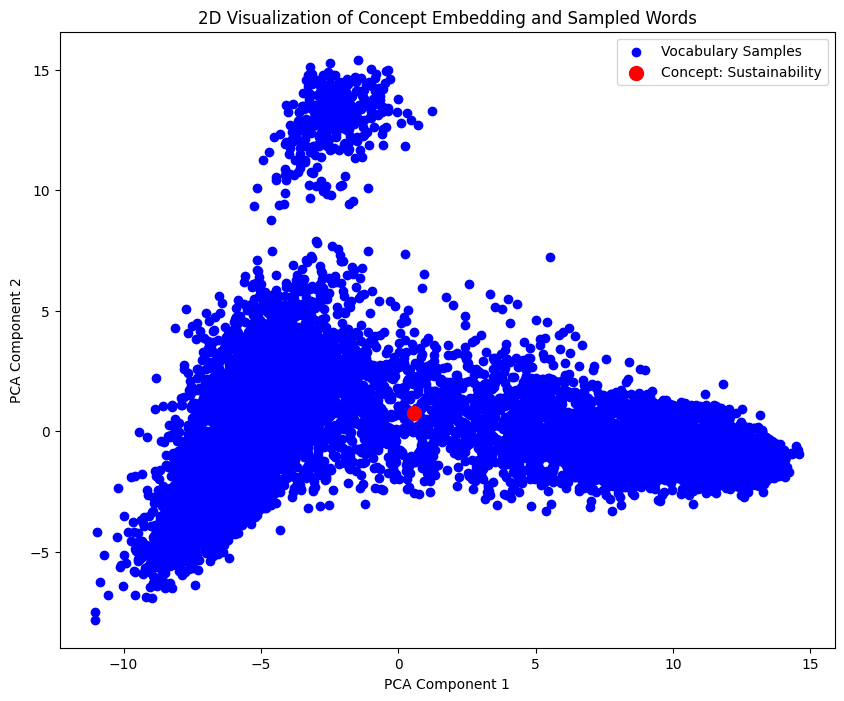

In [28]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Add the concept embedding to the list of embeddings
all_embeddings = word_embeddings + [concept_embedding]

# Apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(all_embeddings)

# Plot the reduced embeddings
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:-1, 0], reduced_embeddings[:-1, 1], color='blue', label='Vocabulary Samples')
plt.scatter(reduced_embeddings[-1, 0], reduced_embeddings[-1, 1], color='red', label='Concept: Sustainability', s=100)

# Add labels and a legend
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D Visualization of Concept Embedding and Sampled Words')
plt.legend()
plt.show()


In [29]:
## add it to df
df['density'] = df['English'].map(embeddings)

## save it to csv
df.to_csv(answerfolder + '/concept_similarity_and_density.csv', index=False)

## The same but with Dutch model

In [33]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('wietsedv/bert-base-dutch-cased')
model = BertModel.from_pretrained('wietsedv/bert-base-dutch-cased')


c:\Users\kadava\AppData\Local\anaconda3\envs\BERT\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kadava\.cache\huggingface\hub\models--wietsedv--bert-base-dutch-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of BertModel were not initialized from the model checkpoint at wietsed

In [34]:
# load in similarity_comparison.csv
df = pd.read_csv(answerfolder + '/similarity_comparison.csv')

# from col English, make list that we want to compute density for
words = list(df['word'])

In [36]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# prepare empty dictionary
embeddings = {}

# Convert tokenizer vocab keys to a list
vocab_list = list(tokenizer.vocab.keys())

# Sample a subset of words from the BERT vocabulary
# For example, let's sample 1000 words from the vocabulary
vocab_sample = np.random.choice(vocab_list, size=10000, replace=False)

# Get embeddings for the sampled words
word_embeddings = [get_embedding(word) for word in vocab_sample]

for word in words:
    print(f"Embedding for {word}")

    # Get the embedding for the concept (e.g., "sustainability")
    concept_embedding = get_embedding(word)

    # Calculate cosine similarities between the concept and the sampled words
    similarities = [cosine_similarity([concept_embedding], [embedding])[0][0] for embedding in word_embeddings]

    # Calculate average distance (1 - similarity)
    avg_distance = np.mean([1 - sim for sim in similarities])

    # Calculate density (inverse of average distance)
    density = 1 / avg_distance

    # Save the density to the dictionary
    embeddings[word] = density

Embedding for bloem
Embedding for dansen
Embedding for bitter
Embedding for vechten
Embedding for ademen
Embedding for bijten
Embedding for zoemen
Embedding for fluisteren
Embedding for walgen
Embedding for langzaam
Embedding for auto
Embedding for eten
Embedding for ei
Embedding for zwemmen
Embedding for snel
Embedding for regen
Embedding for boos
Embedding for luidruchtig
Embedding for luidruchtig
Embedding for snel
Embedding for olifant
Embedding for verdrietig
Embedding for koud
Embedding for staan
Embedding for stil
Embedding for lopen
Embedding for bang
Embedding for gooien
Embedding for haasten
Embedding for gek
Embedding for rennen
Embedding for likken
Embedding for klein
Embedding for onweer
Embedding for man
Embedding for springen
Embedding for langzaam
Embedding for snijden
Embedding for comfortabel
Embedding for kind
Embedding for hoorn
Embedding for kotsen
Embedding for dood
Embedding for drinken
Embedding for sterk
Embedding for oud
Embedding for koken
Embedding for slang

In [37]:
# load in concept_similarity_and_density.csv
df = pd.read_csv(answerfolder + '/concept_similarity_and_density.csv')

# add density_nl to df
df['density_nl'] = df['word'].map(embeddings)

# write to csv
df.to_csv(answerfolder + '/concept_similarity_and_density.csv', index=False)